In [201]:
import json
import cv2 as cv
import pickle as pkl
from typing import Dict, List
import numpy as np
from matplotlib import pyplot as plt
import os, sys
import librosa

from scipy import stats, spatial, ndimage
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
from Signal_processing_utils import intensity_from_signal, pitch_from_signal, sparse_key_smoothing, laplacian_smoothing
from Speech_Data_util import Sentence_word_phone_parser
from prototypes.InputDataStructures import Dietic_Conversation_Gaze_Scene_Info
from prototypes.MVP.MVP_static_saliency_list import ObjectBasedFixSaliency
from prototypes.MVP.MVP_Aversion_saliency_list import AversionSignalDrivenSaliency, CTSAversionSignalDrivenSaliency
from prototypes.MVP.MVP_look_at_point_planner import HabituationBasedPlanner, RandomPlanner, PartnerHabituationPlanner
from prototypes.MVP.MVP_eye_head_driver import HeuristicGazeMotionGenerator
from prototypes.MVP.MVP_Aversion_saliency_list import Base_Static_Saliency_List
from prototypes.EyeCatch.Saccade_model_with_internal_model import *
from prototypes.Gaze_aversion_prior.Heuristic_model import *
from prototypes.Boccignone2020.Gaze_target_planner import Scavenger_based_planner
from prototypes.Boccignone2020.Improved_gaze_target_planner import Scavenger_planner_with_nest, Scavenger_planner_simple 
from prototypes.JaliNeck.JaliNeck import NeckCurve
from prototypes.Gaze_aversion_prior.Ribhav_model import predict_aversion
from prototypes.InputDataStructures import AgentInfo, TurnTakingData
from prototypes.MVP.MVP_gaze_path_planner import Responsive_planner_simple
import pickle
import math
from datetime import datetime, timezone
import scipy.stats as ss
from Signal_processing_utils import interpolate1D, runEuro, intensity_from_signal
import numpy as np
from scipy.interpolate import interp1d

In [202]:
%load_ext autoreload
%autoreload 1
%aimport prototypes.InputDataStructures
%aimport Signal_processing_utils
%aimport Speech_Data_util
%aimport prototypes.MVP.MVP_static_saliency_list
%aimport prototypes.EyeCatch.Saccade_model_with_internal_model
%aimport prototypes.InputDataStructures
%aimport prototypes.Jin2019.EyeHeadDecomposition
%aimport prototypes.Optimization_based_head_eye_seperator.Baseline_optimization
%aimport prototypes.Boccignone2020.Improved_gaze_target_planner
%aimport prototypes.MVP.MVP_gaze_path_planner
%aimport prototypes.JaliNeck.JaliNeck


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
# inputs
input_folder = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"
# input_folder = "F:/MASC/Ribhav_processed_dataset/"
# input_file = "Stranger Things’ Dacre Montgomery’s Insane _Billy_ Audition Tape ｜ GQ"
input_file = "Madelaine Petsch audition for The Prom"

input_scene_data_path = "/Users/evanpan/Documents/GitHub/Gaze_project/data/look_at_points/simplest_scene.json"
speaker_id = 1
shot_id = 1
turn_taking_threshold = 2
fps = 24
np.random.seed(speaker_id + shot_id)


In [204]:

input_file_no_space = "_".join(input_file.split(" "))
# input_file_no_space = "'" + input_file_no_space + "'"
shot_file_name = os.path.join(os.path.join(os.path.join(input_folder, "shots"), input_file), "shot_cuts.json")
video_path = os.path.join(*[input_folder, "video", input_file+".mp4"])
audio_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.wav".format(shot_id, 1))
audio_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.wav".format(shot_id, 2))
script_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.txt".format(shot_id, 1))
script_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.txt".format(shot_id, 2))
praatoutput_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}_PraatOutput.txt".format(shot_id, 1))
praatoutput_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}_PraatOutput.txt".format(shot_id, 2))
head_direction_json_path = os.path.join(*[input_folder, "pose", input_file+".pkl"])
gaze_direction_json_path = os.path.join(*[input_folder, "L2CSNet", input_file+".json"])
landmarks_mediapipe_json_path = os.path.join(*[input_folder, "faces", input_file+" faces.pkl"])
python_out_location = os.path.join(*[input_folder, "outputs", input_file_no_space+".pkl"])
scene_file_out_location = os.path.join(*[input_folder, "annotated_scene", input_file+".json"])
animation_file_path = os.path.join(*[input_folder, "outputs", input_file+".json"])
gd_file_path = os.path.join(*[input_folder, "outputs", input_file+"_gaze_deploy.json"])
st_file_path = os.path.join(*[input_folder, "outputs", input_file+"_stare.json"])
ss_file_path = os.path.join(*[input_folder, "outputs", input_file+"_static_salience.json"])

scene_data_path = os.path.join(*[input_folder, "annotated_scene", input_file+".json"])

# =================== JALI related ===================
# sementic_script_1 = Sentence_word_phone_parser(praatoutput_1_path, script_1_path)
# sementic_script_1.get_turns(turn_taking_threshold)
# sementic_script_2 = Sentence_word_phone_parser(praatoutput_2_path, script_2_path)
# sementic_script_2.get_turns(turn_taking_threshold)
audio_1, sr= librosa.load(audio_1_path, sr=44100)
audio_2, sr= librosa.load(audio_2_path, sr=44100)
# agentScene1 = AgentInfo(scene_data_path)
# agentScene2 = AgentInfo(scene_data_path)

/Users/evanpan/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/JaliTranscript/Madelaine_Petsch_audition_for_The_Prom/shot_1_1.wav'

# Get the beat from the audio as per Rhythmic Gesticulator

In [198]:
# get the energy and derivative
audio = audio_1
fps = 50
audio_energy = intensity_from_signal(audio, int(sr/fps))
beat_ts = np.arange(0, audio_energy.shape[0]) / fps
daudio_dt = dx_dt(audio_energy)
Dm = 0.2
DM = 0.7
DM_frame = math.floor(DM / (beat_ts[1] - beat_ts[0]))
energy_interp = interp1d(beat_ts, audio_energy, bounds_error=False)

In [199]:
# iterative find audio onset between 0.2 and 0.6 seconds to identify beats
beats = [[0, False]] # start with a pseudo beat
for i in range(0, audio_energy.shape[0]):
    if daudio_dt[i] > 5:
        current_beat_t = beat_ts[i]
        if current_beat_t - beat_ts[beats[-1][0]] <= Dm:
            continue
        if current_beat_t - beat_ts[beats[-1][0]] >= DM:
            # these are stored as integer indexes
            start = beats[-1][0]
            end = i
            counter = start + DM_frame
            while counter < end:
                beats.append([counter, False])
                counter = counter + DM_frame
        beats.append([i, True])
# turn beats into an impulse array

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_78381/3891183236.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(beats_arr[:, 0], beats_arr[:, 1], c=[1, 0, 0])


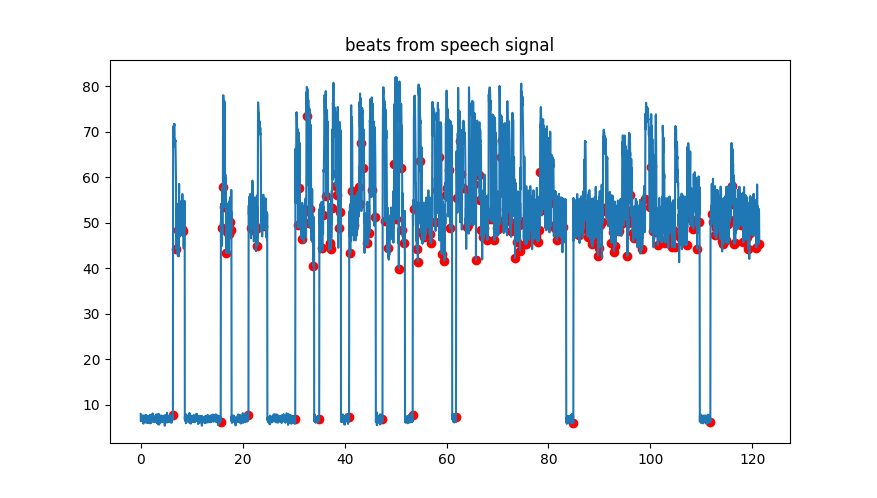

In [200]:
# find a way to plot the beats
beats_arr = []
for i in range(0, len(beats)):
    if beats[i][1]:
        beats_arr.append([beat_ts[beats[i][0]], audio_energy[beats[i][0]]])
beats_arr = np.array(beats_arr)
plt.cla()
plt.title("beats from speech signal")
plt.plot(beat_ts, audio_energy)
plt.scatter(beats_arr[:, 0], beats_arr[:, 1], c=[1, 0, 0])
plt.show()

# Get the gaze/neck data from file

In [131]:
# load head angle data
all_head_data = pkl.load(open(head_direction_json_path, "rb"))
head_angle_data = all_head_data["HEAD"]
head_rotmat_per_frame = head_angle_data["ROTMAT"]
head_bbox_per_frame = all_head_data["BBOX"] # this is largely useless 
head_angle_per_frame = []
neutral_position = np.array([0, 0, 100])
for i in range(0, head_rotmat_per_frame.shape[0]):
    pos = head_rotmat_per_frame[i] @ neutral_position
    head_angle_per_frame.append(rotation_angles_frome_positions(pos[:]))
head_angle_per_frame = np.array(head_angle_per_frame)
# getting rotation angle in z direction
neutral_position2 = np.array([0, 100, 0])
head_angle_z_per_frame = []
for i in range(0, head_rotmat_per_frame.shape[0]):
    pos = head_rotmat_per_frame[i] @ neutral_position2
    pos = np.array([pos[1], pos[2], pos[0]])
    head_angle_z_per_frame.append(rotation_angles_frome_positions(pos)[1])
head_angle_xy_per_frame = np.array(head_angle_per_frame)
head_angle_z_per_frame = np.expand_dims(np.array(head_angle_z_per_frame), axis=1)
head_angle_per_frame = np.concatenate([head_angle_xy_per_frame, head_angle_z_per_frame], axis=1)

# load gaze data (L2CS)
all_gaze_data = pkl.load(open(gaze_direction_json_path, "rb"))
gaze_angle_data = all_gaze_data["RAW_GAZE"]
gaze_angle_per_frame = gaze_angle_data["EULER"]
gaze_rotmat_per_frame = gaze_angle_data["ROTMAT"]
blinks = all_head_data["BLINKS"]
gaze_vec = np.array([0, 0, 100])
eye_angle_per_frame = []
for i in range(0, gaze_rotmat_per_frame.shape[0]):
    eye_line = gaze_rotmat_per_frame[i] @ gaze_vec
    eye_line = eye_line / eye_line[2] * 100
    eye_angle_per_frame.append(eye_line)
eye_angle_per_frame = np.array(eye_angle_per_frame)
eye_angle_per_frame = rotation_angles_frome_positions(eye_angle_per_frame[:])

# time vector
eye_ts = np.arange(0, eye_angle_per_frame.shape[0])/fps

In [132]:
def dispersion_filtering(x, y, dispersion_threshold = 8, duraiton_threshold=0.2):
    start = 0
    window = []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)

    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixation_points = []
    fixation_frames = []

    fixation_points_interval = []
    fixation_frames_interval = []
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        while disp <= dispersion_threshold:
            disp = dispersion(y[window])
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            
        # if the current set of points never fit the duration criteria
        if len(window) == duration_threshold_frames:
            start = start + 1
        else:
            centroid = np.mean(y[window], axis=0)
            for w in window:
                fixation_points.append(centroid)
                fixation_frames.append(w)
            fixation_points_interval.append(centroid)
            fixation_frames_interval.append([window[0], window[-1]])
    return np.array(fixation_frames), np.array(fixation_points), fixation_frames_interval, fixation_points_interval

In [165]:
fixation_frames, fixation_points, fixation_frames_interval, fixation_points_interval = dispersion_filtering(eye_ts, eye_angle_per_frame, 4)

# Determine the percentage of fixation that falls within a beat

In [194]:
pmb = 0
threshold = 0.15
# we only count for gaze_shifts that occurs during speech turn
count_fixation_frames_speaking = 0
for i in range(0, len(fixation_frames_interval)):
    saccade_t = eye_ts[fixation_frames_interval[i][1]]
    saccade_interval = fixation_frames_interval[i]
    energy_of_interval = np.arange(eye_ts[saccade_interval[0]], eye_ts[saccade_interval[1]], 1/fps)
    if energy_interp(energy_of_interval).mean() >= 45:
        count_fixation_frames_speaking = count_fixation_frames_speaking + 1
        for j in range(0, beats_arr.shape[0]):
            beats_t = beats_arr[j, 0]
            if abs(beats_t - saccade_t) <= threshold:
                pmb = pmb + 1
                break
pmb = pmb / count_fixation_frames_speaking
print(pmb)

0.7019230769230769


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_78381/3995674523.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(beats_arr[:, 0], beats_arr[:, 1], c=[1, 0, 0], label="beats")
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_78381/3995674523.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(saccade_arr[:, 0], saccade_arr[:, 1], c=[0, 1, 0], label="saccade")


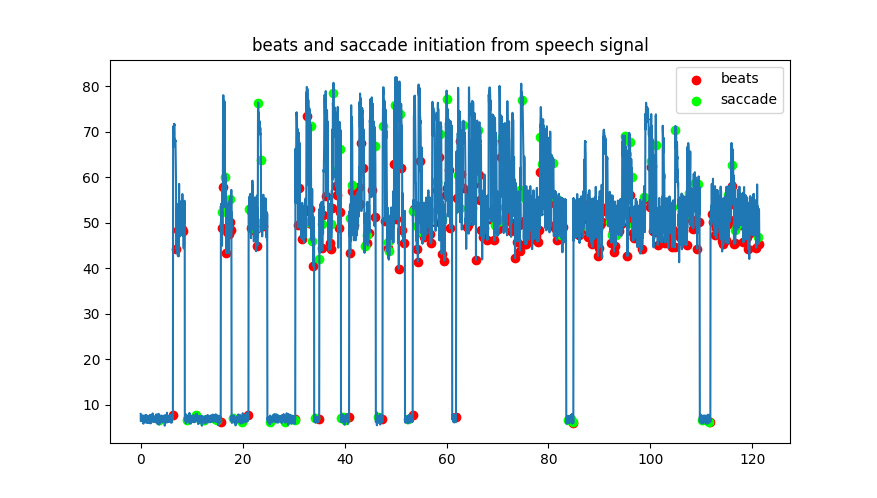

In [192]:
# find a way to plot the beats
beats_arr = []
for i in range(0, len(beats)):
    if beats[i][1]:
        beats_arr.append([beat_ts[beats[i][0]], audio_energy[beats[i][0]]])
saccade_arr = []
fixation_frames_interval
for i in range(0, len(fixation_frames_interval)):
    try:
        saccade_arr.append([eye_ts[fixation_frames_interval[i][1]], energy_interp(eye_ts[fixation_frames_interval[i][1]])])
    except:
        break
saccade_arr = np.array(saccade_arr)
beats_arr = np.array(beats_arr)
plt.cla()
plt.title("beats and saccade initiation from speech signal")
plt.plot(beat_ts, audio_energy)
plt.scatter(beats_arr[:, 0], beats_arr[:, 1], c=[1, 0, 0], label="beats")
plt.scatter(saccade_arr[:, 0], saccade_arr[:, 1], c=[0, 1, 0], label="saccade")
plt.legend()
plt.show()